# AOS DM-33111 analyze November data

Chris Suberlak, 03/16/22 

Analysis of the November auxTel data https://confluence.lsstcorp.org/display/LSSTCOM/2021-11-04+Aux-Tel+Night+Log , which included a series of 20 intra-focal exposures (`308-318`) and a series of 20 extra-focal exposures (`339-349`).  Each exposure is 5 sec. 
We first consider the effect of temporal separation  between exposures, as their separation becomes greater than the timescale of atmospheric changes. We also stack postISR exposures to simulate series of progressively longer exposures to test the effect of the combined increase in S/N on the rms in retrieved Zernikes. We compare the rms in Zernikes against integration time treating the longest "stack" as truth. 
We repeat exposures on each side of the focus (rather than having extra/in-focus/intra) is to exclude the effects due to moving the hexapod when coadding the images. 


Setup:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    source /project/scichris/aos/setup_aos_current.sh
    jupyter notebook --no-browser --port=54467
    
Last verified to run 03/16/22, using NCSA stack `w_2022_11`. The notebook used data from : `211104` , log https://confluence.lsstcorp.org/display/LSSTCOM/2021-11-04+Aux-Tel+Night+Log and pdf with notebook used to run the telescope https://confluence.lsstcorp.org/download/attachments/168857232/Donut_5s_intra_extra.pdf?version=1&modificationDate=1636081198000&api=v2

Run the ISR:
    
    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/queries.html#dimension-expressions

    pipetask run  --data-query "exposure IN (2021110400299..2021110400358) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRtest --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types
   
   
When I try to run that I get 

    FileNotFoundError: Not enough datasets (0) found for non-optional connection isr.flat (flat) with minimum=1 for quantum data ID {instrument: 'LATISS', detector: 0, exposure: 2021110400299, ...}
    
So I try to run with `doApplyGains` rather than `doFlat` : 

    pipetask run  --data-query "exposure IN (2021110400299..2021110400358) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRtest --pipeline /project/scichris/aos/testLatiss4_noFlat.yaml  --register-dataset-types


## Preview the raw exposures

In [2]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import numpy as np 
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


def preview_auxtel_exposures(year='2021', monthDay='0908', expStart=483, expEnd=490,
                            datasetRefOrType='raw', collection='LATISS/raw/all'):

    butler = dafButler.Butler('/repo/main/')
    
    # figure out how many images to plot
    nexp = expEnd-expStart

    # calculate how many cols and rows we need 
    if nexp > 3:
        ncol = 3
        nrows = (nexp // ncol) + 1
    else:
        ncol=nexp
        nrows = 1
        
    zscale = ZScaleInterval()
    # do the plotting 
    fig,axs = plt.subplots(nrows,ncol,figsize=(ncol*4,nrows*4))
    ax = np.ravel(axs)
    i=0
    for exp in range(expStart,expEnd+1):
        exposure = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{exp}')
                                            },
                          collections=[collection])
        data = exposure.image.array
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data,vmin=vmin,vmax=vmax,origin=
                  'lower')
        ax[i].set_title(f"{year}{monthDay}, exp {exp},\n focusz={np.round(exposure.getMetadata()['FOCUSZ'],3)}")
        i += 1
    fig.subplots_adjust(hspace=0.35)

    # if there are more axes than exposures,
    # turn off the extra axes 
    ncells = nrows*ncol
    if ncells > nexp:
        for axis in ax[nexp:]:
            axis.axis("off")

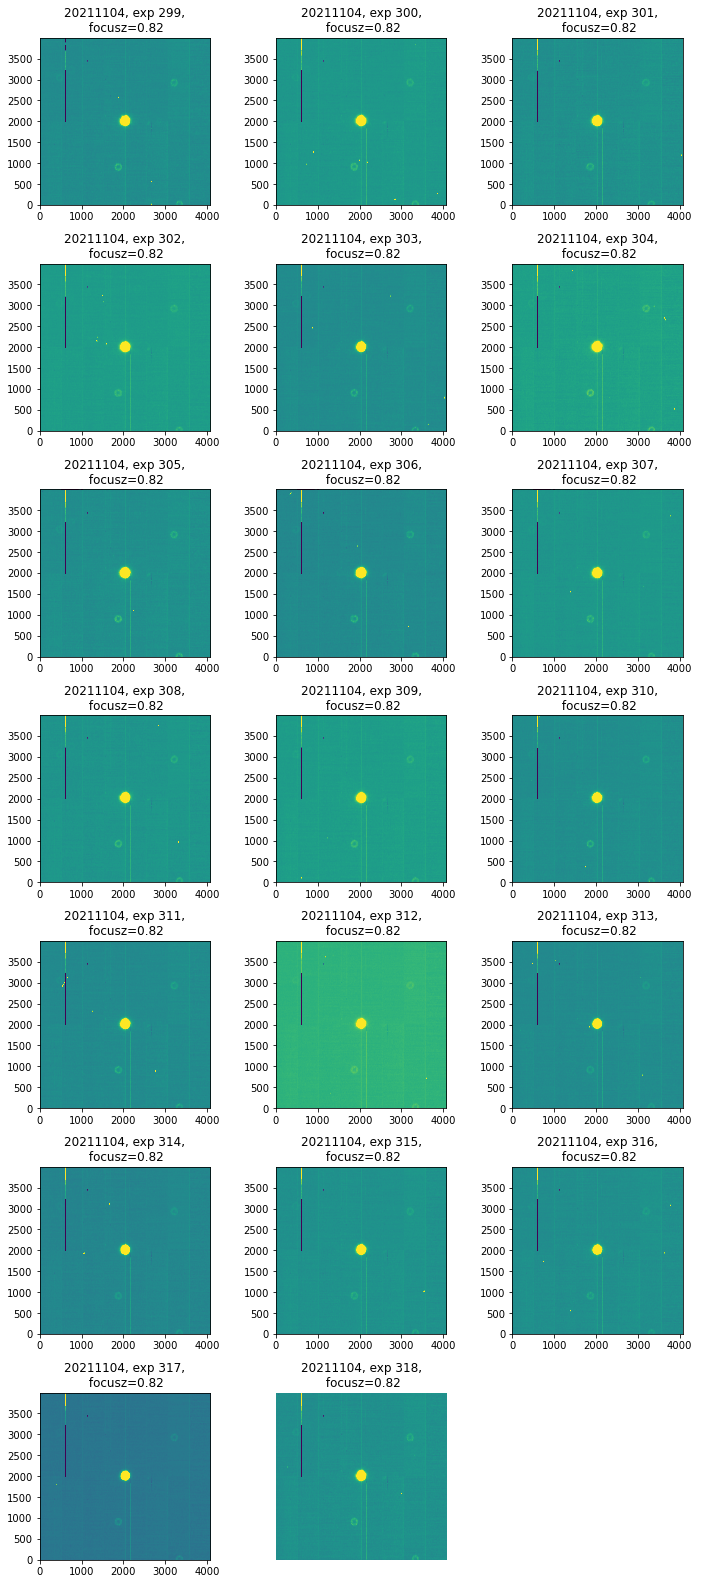

In [2]:
# show the intra-focal
preview_auxtel_exposures(year='2021', monthDay='1104', expStart=299, expEnd=318,
                            datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest')

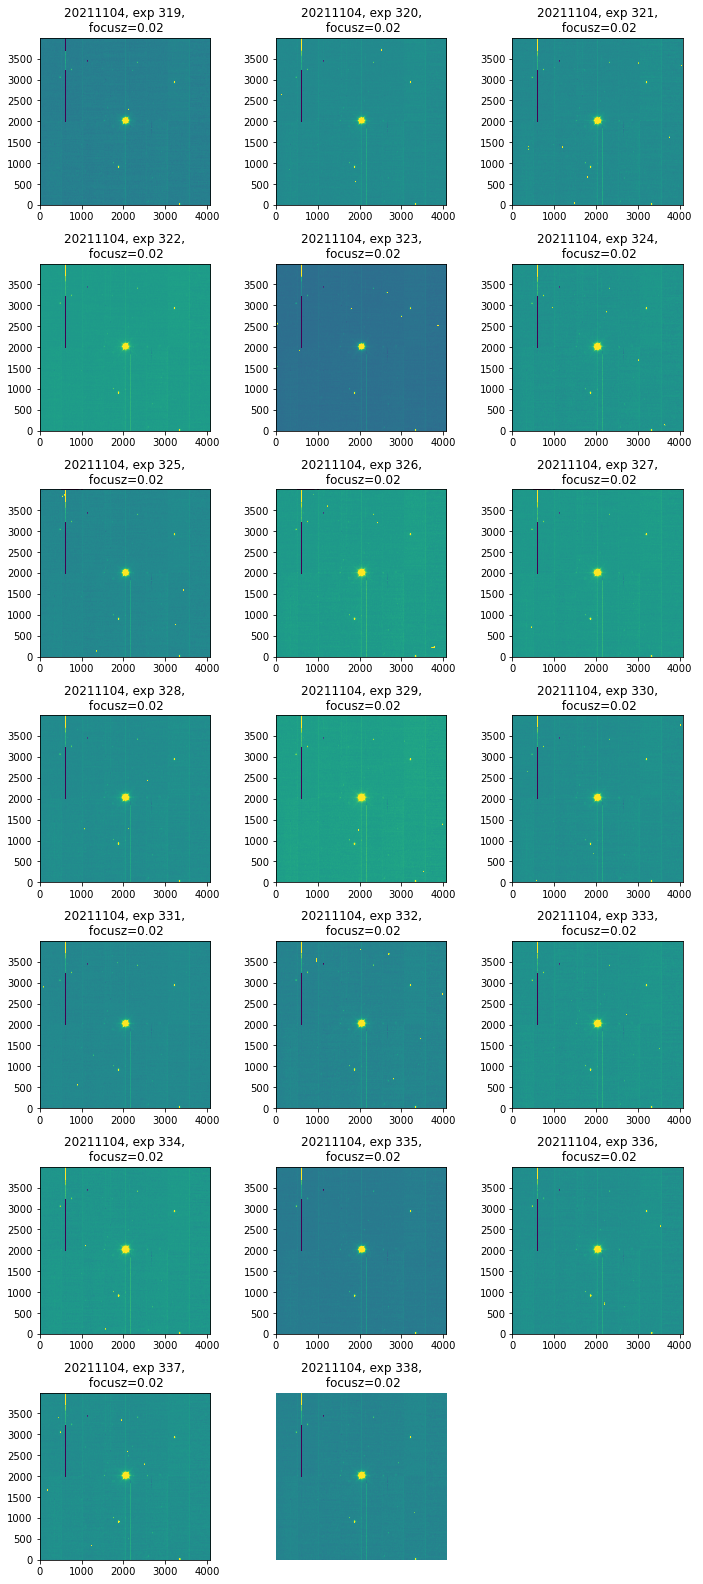

In [3]:
# show the in-focus
preview_auxtel_exposures(year='2021', monthDay='1104', expStart=319, expEnd=338,
                            datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest')

## List the extra/ intra focal shifts 

For Latiss, the negative value is extra-focal (z-axis points down
towards M1 mirror):

    --- extra --0-- intra ----> (+z)

If both are negative, we assume that the one
more negative is extra-focal:

    --- extra ----- intra --0--> (+z)


In [4]:
# Read in the results and store in a dictionary 
expExtra = [464, 466, 468, 470, 473, 476, 479, 482, 485, 488, 491, 494]
focusz = {}

butler = dafButler.Butler('/repo/main/')
year='2021'
monthDay='0707'
datasetRefOrType='raw'
collection='LATISS/raw/all'


for exp in expExtra:

    exposure_extra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{exp}')
                                        },
                      collections=[collection])
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':int(f'{year}{monthDay}00{exp+1}')
                                        },
                      collections=[collection])
    focusz[exp] = exposure_extra.getMetadata()['FOCUSZ']
    focusz[exp+1] = exposure_intra.getMetadata()['FOCUSZ']

/lsstdata/offline/instrument/LATISS/storage/2021-07-07/AT_O_20210707_000464-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-07-07/AT_O_20210707_000465-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-07-07/AT_O_20210707_000466-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-07-07/AT_O_20210707_000467-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-07-07/AT_O_20210707_000468-R00S00.fits: outAmp.getRawBBox() != data.getBBox

In [5]:
print("date      expExtra, focusz  expIntra, focusz")
for exp in expExtra:
    print(f"{year}{monthDay} {exp:>6d} {focusz[exp]:>7.3f} {exp+1:6d}  {focusz[exp+1]:>6.3f}  ")

date      expExtra, focusz  expIntra, focusz
20210707    464  -2.382    465  -0.782  
20210707    466  -2.377    467  -0.777  
20210707    468  -2.379    469  -0.779  
20210707    470  -2.390    471  -0.790  
20210707    473  -2.393    474  -0.793  
20210707    476  -2.387    477  -0.787  
20210707    479  -2.389    480  -0.789  
20210707    482  -2.396    483  -0.796  
20210707    485  -2.391    486  -0.791  
20210707    488  -2.390    489  -0.790  
20210707    491  -2.385    492  -0.785  
20210707    494  -2.390    495  -0.790  


## Pairs of exposures separated by increasing time

From the above construct intra/extra pairs to pass to the `GenerateDonutDirectDetectTask` to detect donuts and create donut catalog;  this is then used in  `EstimateZernikesLatissTask`  to calculate Zernike coefficients. We first fit zernikes to pairs of exposures separated by increasing time difference. 

Initialize tasks with the same config for all fits:

In [52]:
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
    EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
)

donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend') # adaptative image thresholding
donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)


estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)



In [53]:
# initialize the butler
butler = dafButler.Butler('/repo/main/')

# load the exposure pair
year='2021'
monthDay='1104'
datasetRefOrType='postISRCCD'
collection='u/scichris/Latiss/postISRtest'



In [59]:
# Make lists of exposure pairs, print their temporal separation in sec
expIntra = np.arange(299,319)[::-1]
expExtra = np.arange(339,359)

print('intra extra dt')
for expI, expE in zip(expIntra,expExtra):
    print(expI,expE, 5*(expE-expI))

intra extra dt
318 339 105
317 340 115
316 341 125
315 342 135
314 343 145
313 344 155
312 345 165
311 346 175
310 347 185
309 348 195
308 349 205
307 350 215
306 351 225
305 352 235
304 353 245
303 354 255
302 355 265
301 356 275
300 357 285
299 358 295


In [55]:
year='2021'; monthDay='1104'; expIntra=316 ; expExtra=341

# load the intra and extra-focal exposures 
exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{expIntra}')
                                            }, collections=[collection])

exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{expExtra}')
                                            }, collections=[collection])
camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                    collections=[collection],)

# find donuts from one of the exposures
donutCatalog = donutDetectTask.run(exposure_extra)
donutCat = donutCatalog.donutCatalog

# declare the exposure pair
exposure_pair = [exposure_intra, exposure_extra ]
zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

# store zernikes as dict
zernikes = zernikeOutput.getDict()
fname = f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}_n.npy'
np.save(fname,zernikes, )
print(f'Stored the results as {fname} ')

Stored the results as zerDic_2021110400316_341_n.npy 


In [40]:
def fit_zernikes(donutDetectTask,estimateZernikeTask,
                 expIntra, expExtra, 
                 year='2021', monthDay='1104',
                 collection=collection, use_extra=False):
    # load the intra and extra-focal exposures 
    exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expIntra}')
                                                }, collections=[collection])

    exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expExtra}')
                                                }, collections=[collection])
    camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                        collections=[collection],)
    
    # find donuts from one of the exposures
    if use_extra:
        exposure = exposure_extra.copy()
    else:
        exposure = exposure_intra.copy()
    
    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}_n.npy'
    np.save(fname,zernikes, )
    print(f'Stored the results as {fname} ')



For exp 316 there is a large bad column that prevents the bright donut from being detected, thus I draw the donut position from the extra-focal exposure. For all other pairs the intra-focal exposure works fine. 

In [41]:
# fit zernikes for all pairs     
for expI, expE in zip(expIntra,expExtra):
    if expI == 316:
        use_extra=True
    else:
        use_extra=False
        
    fit_zernikes(donutDetectTask,
                 estimateZernikeTask, 
                 expExtra=expE, 
                 expIntra=expI,
                 use_extra=use_extra
                 )

Stored the results as zerDic_2021110400318_339_n.npy 
Stored the results as zerDic_2021110400317_340_n.npy 
Stored the results as zerDic_2021110400316_341_n.npy 
Stored the results as zerDic_2021110400315_342_n.npy 
Stored the results as zerDic_2021110400314_343_n.npy 
Stored the results as zerDic_2021110400313_344_n.npy 
Stored the results as zerDic_2021110400312_345_n.npy 
Stored the results as zerDic_2021110400311_346_n.npy 
Stored the results as zerDic_2021110400310_347_n.npy 
Stored the results as zerDic_2021110400309_348_n.npy 
Stored the results as zerDic_2021110400308_349_n.npy 
Stored the results as zerDic_2021110400307_350_n.npy 
Stored the results as zerDic_2021110400306_351_n.npy 
Stored the results as zerDic_2021110400305_352_n.npy 
Stored the results as zerDic_2021110400304_353_n.npy 
Stored the results as zerDic_2021110400303_354_n.npy 
Stored the results as zerDic_2021110400302_355_n.npy 
Stored the results as zerDic_2021110400301_356_n.npy 
Stored the results as zerDic

Illustrate the results 

In [62]:
# plot the truth vs simulation... 
def plot_zernike_image(expIntra=318, expExtra=339, year='2021',monthDay='1104'):

    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))

    ####################################
    ### left - plot the fit results  ###
    #################################### 

    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    #for exp in expIntra:
    zkResultsFile = f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}_n.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    for i in range(int(len(zkFit['outputZernikesRaw'])/2)):
        
        ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][i][0], 
                 '-d', label=f'donut {i} ')

    ax1.set_xlabel('Zernike Number',)
    ax1.set_ylabel('Zernike Coefficient [nanometers]', )
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()

    ax1.set_title(f'auxTel {year}{monthDay}, {expIntra}-{expExtra}', fontsize=18)


    ###############################################
    ### right - plot the postISR image ###
    ###############################################


    ax2 = fig.add_axes([0.6,0,0.4,1])
    butler = dafButler.Butler('/repo/main/')
    datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                                 'exposure':int(f'{year}{monthDay}00{expIntra}')
                                                    }, collections=[collection])
    zscale = ZScaleInterval()
    data = exposure_intra.image.array
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

    nrows = int(len(zkFit['donutStampsExtra'])/2)
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.getCentroidPositions()[0]
        print(i,xy)
        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    ax2.set_title(f'exp{expIntra}')

0 (2039, 2022)
0 (2039, 2022)
0 (2039, 2023)
0 (2041, 2025)
0 (2040, 2024)
0 (2041, 2026)
0 (2041, 2019)
0 (2036, 2023)
0 (2039, 2027)
0 (2040, 2028)
0 (2041, 2029)
0 (2041, 2028)
0 (2041, 2027)
0 (2041, 2027)
0 (2040, 2029)
0 (2042, 2027)
0 (2045, 2024)
0 (2044, 2024)
0 (2044, 2025)
0 (2043, 2025)


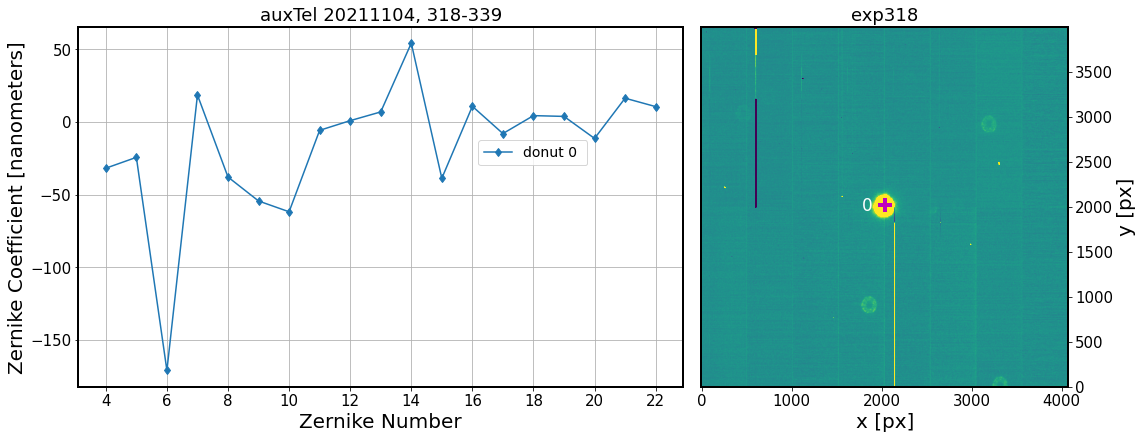

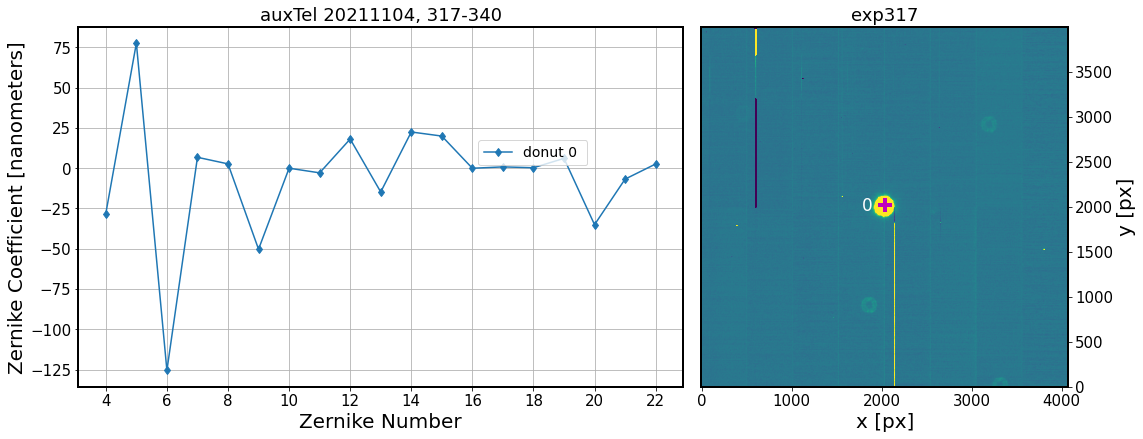

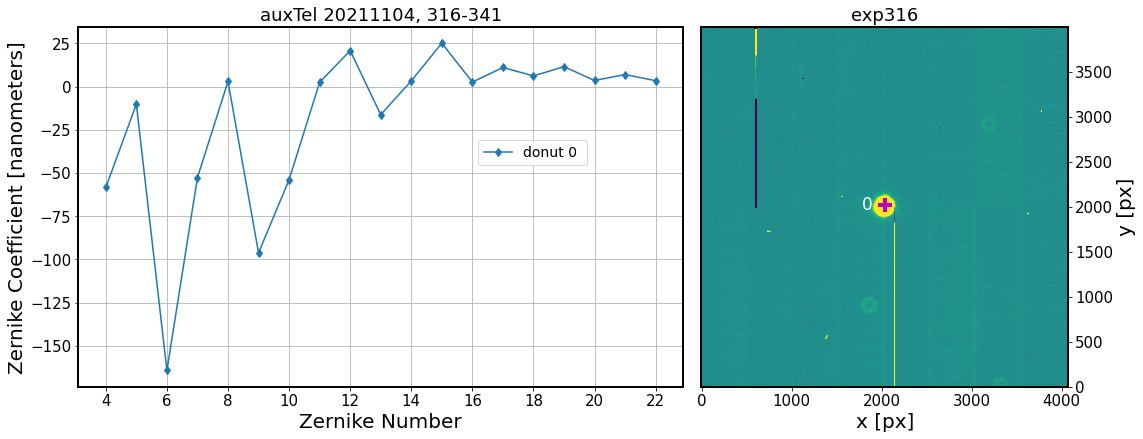

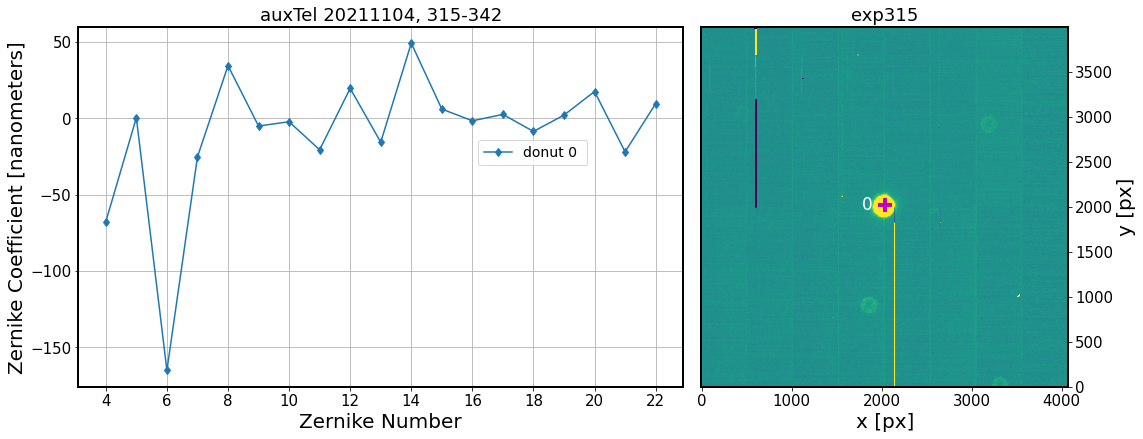

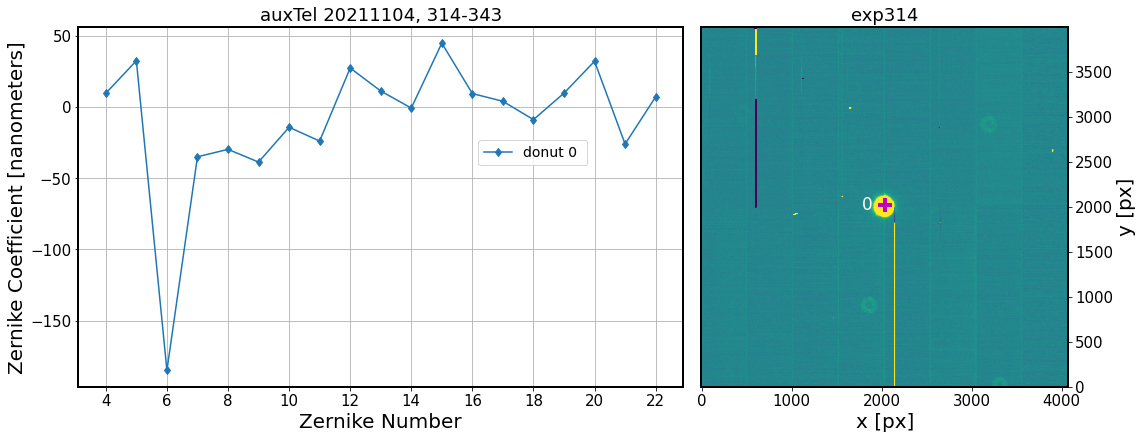

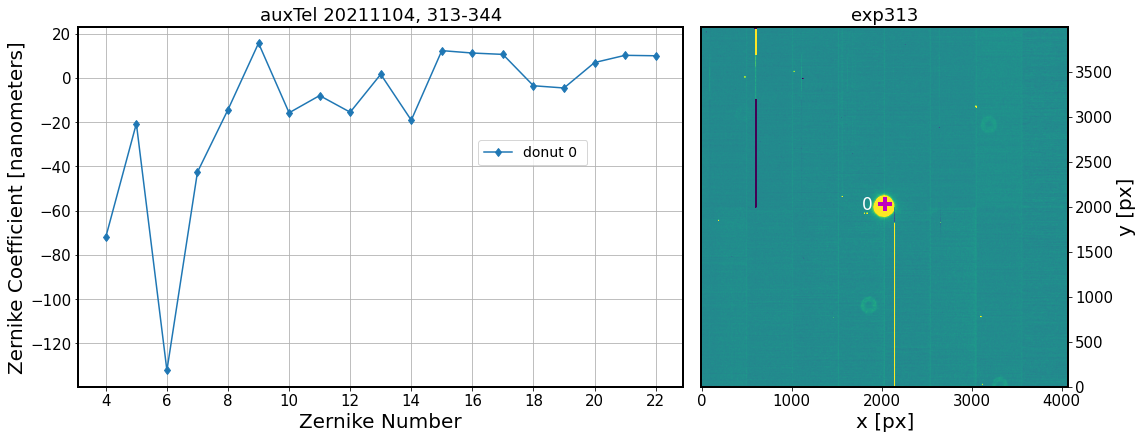

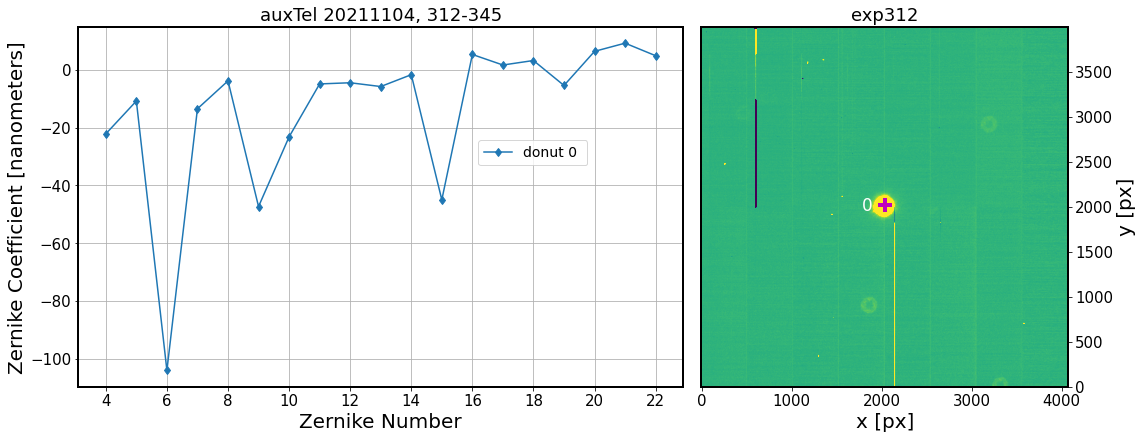

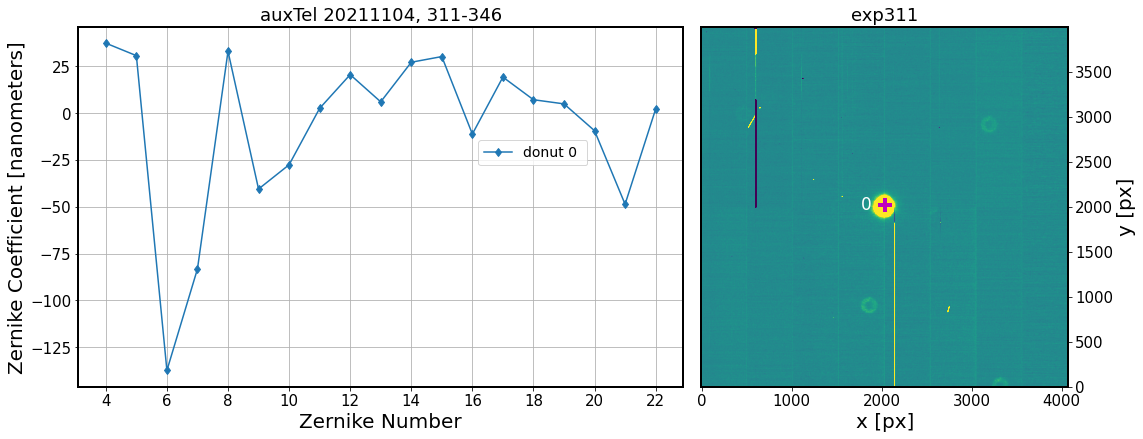

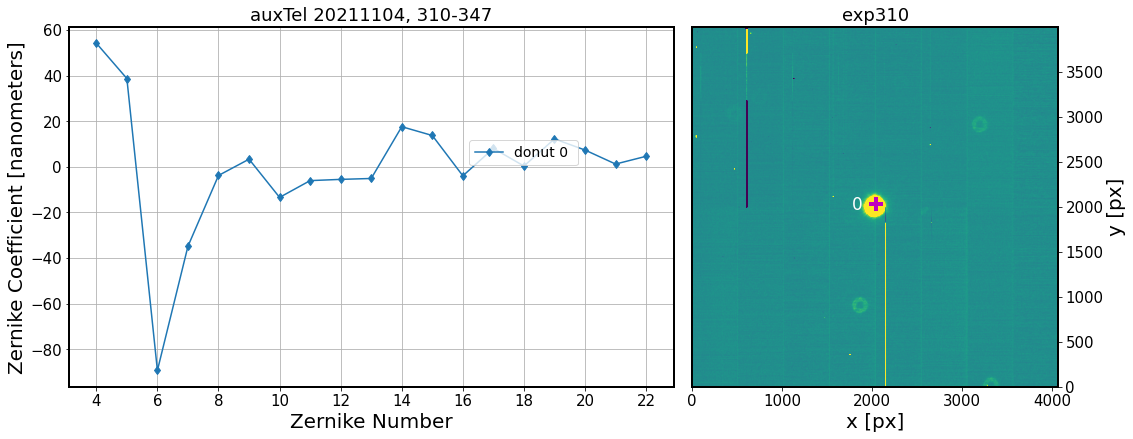

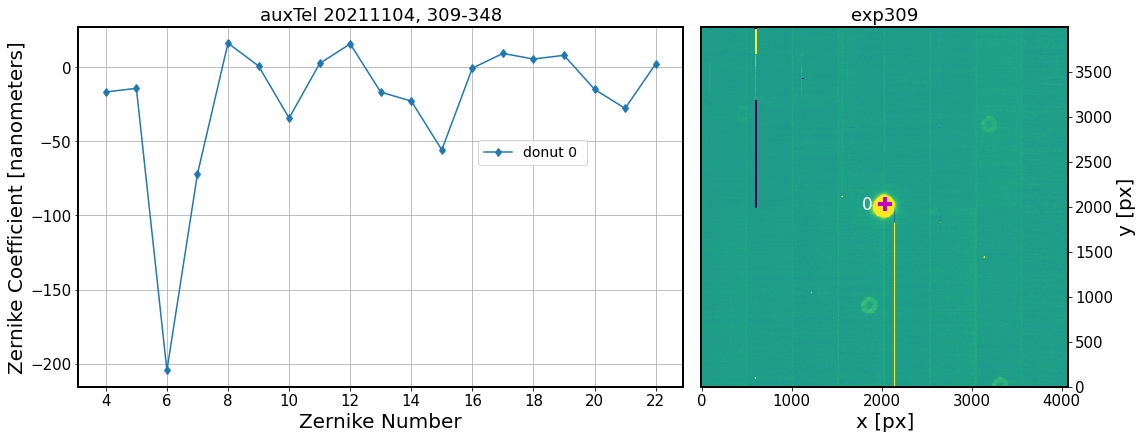

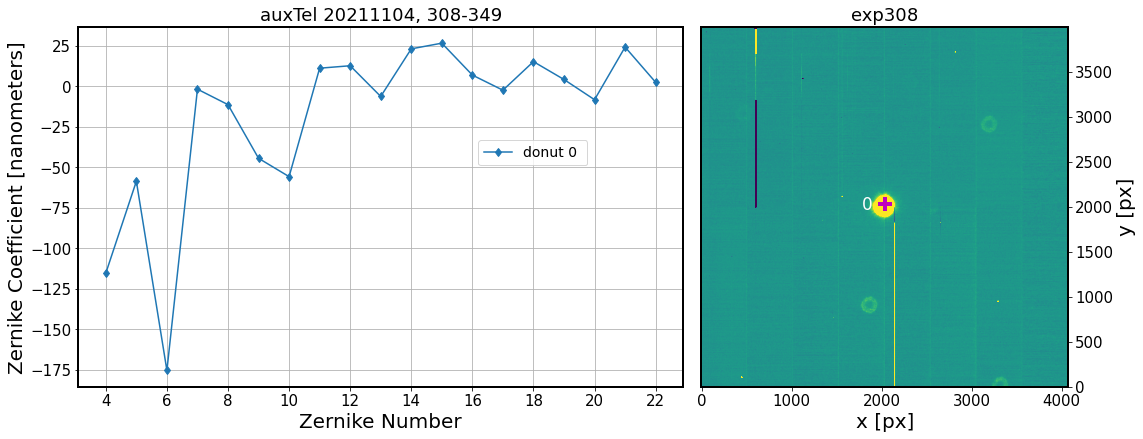

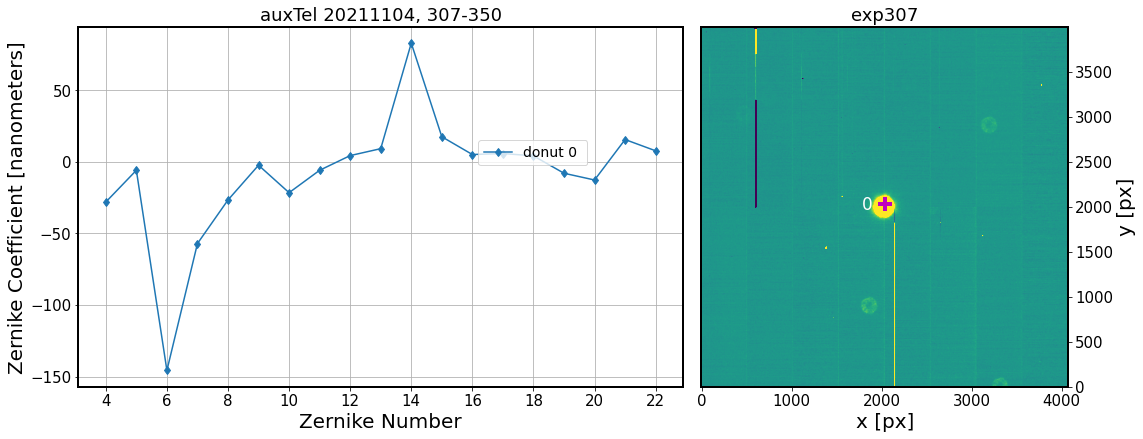

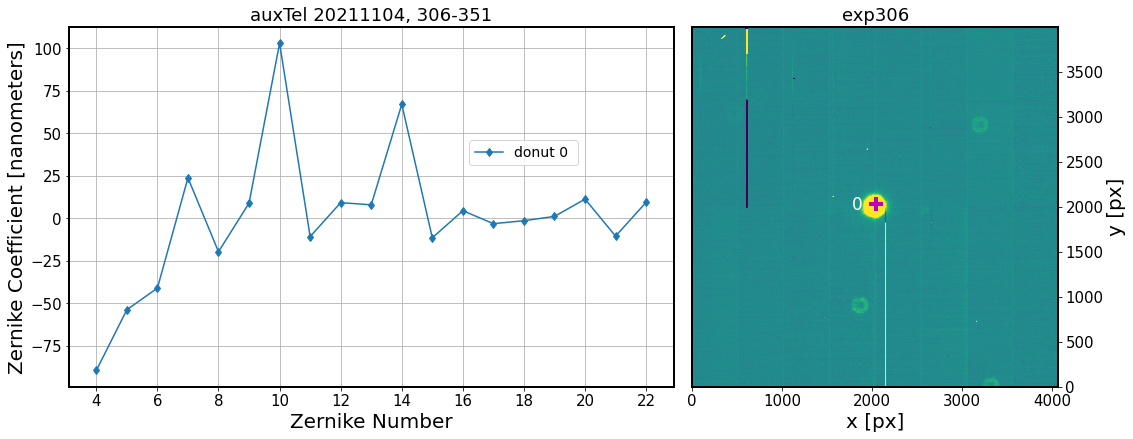

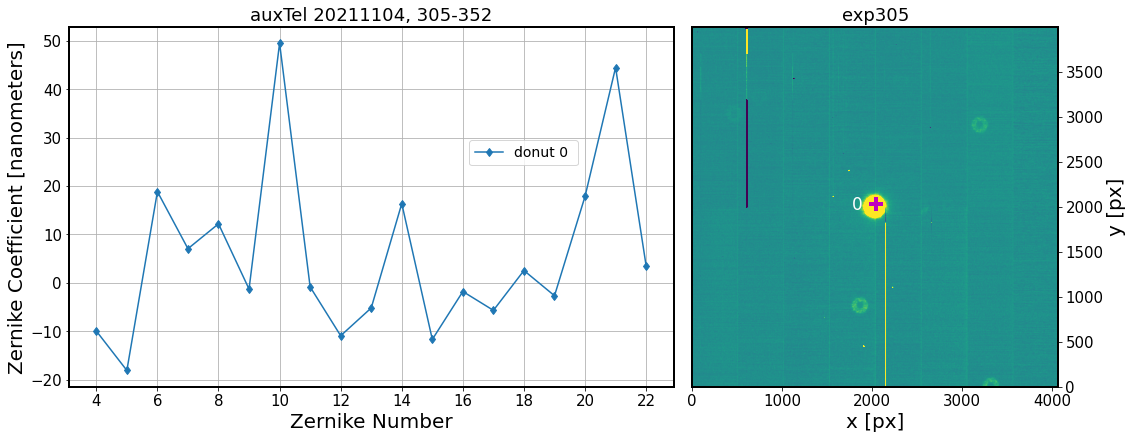

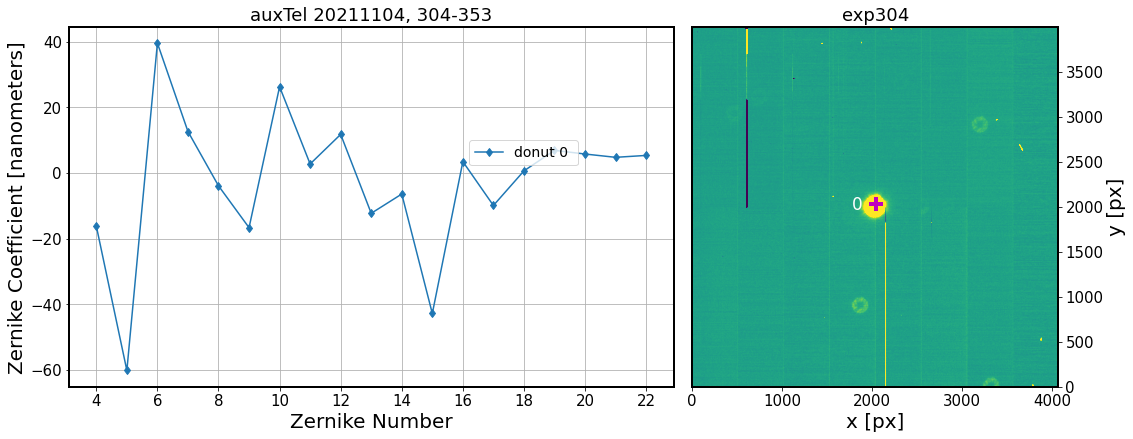

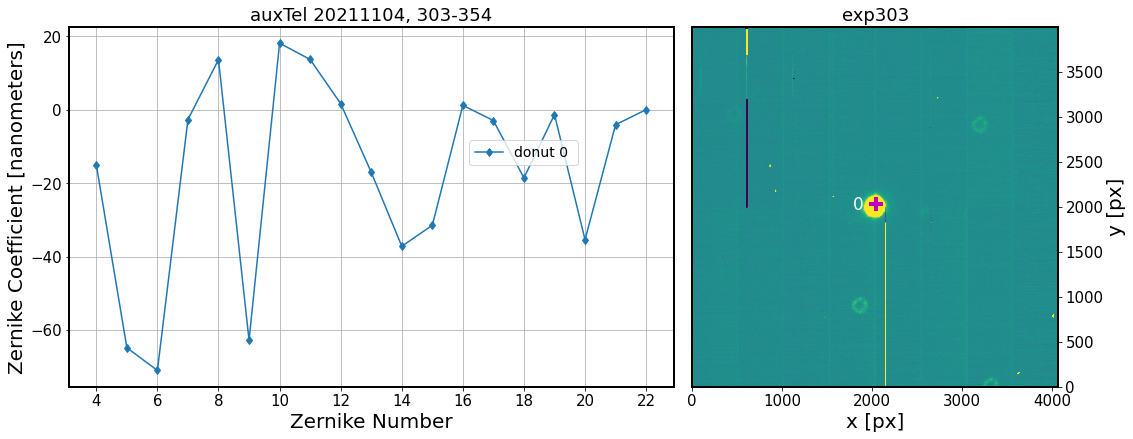

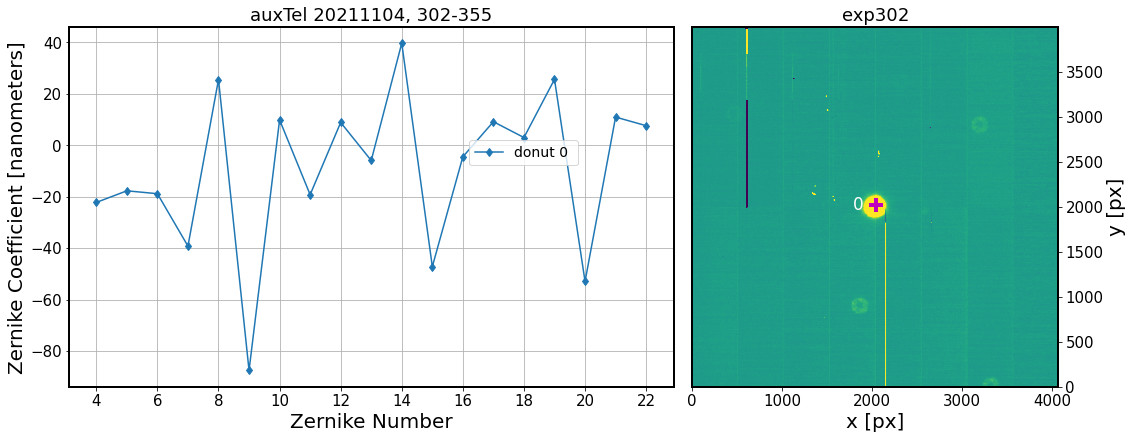

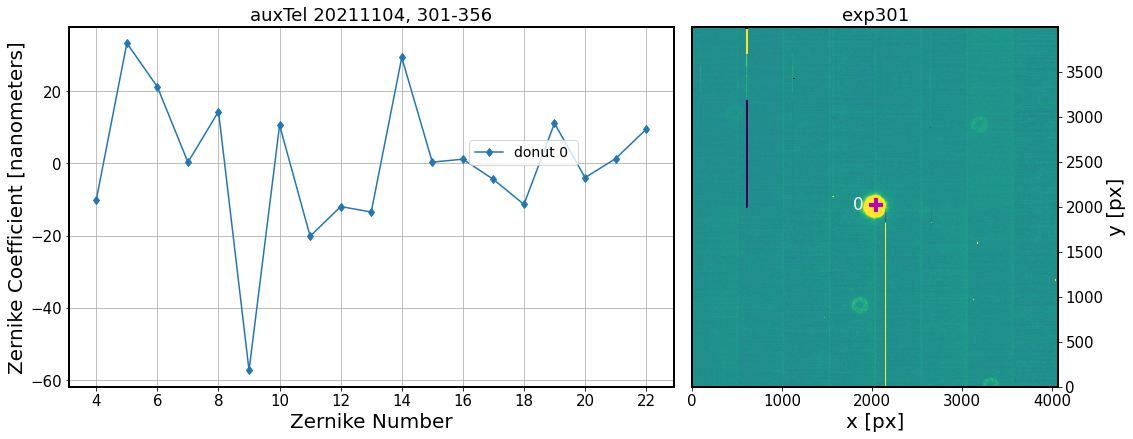

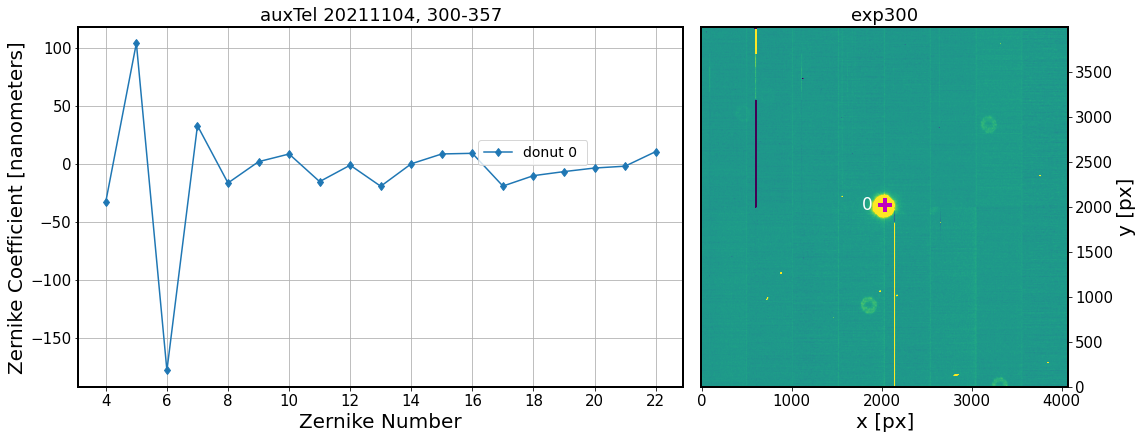

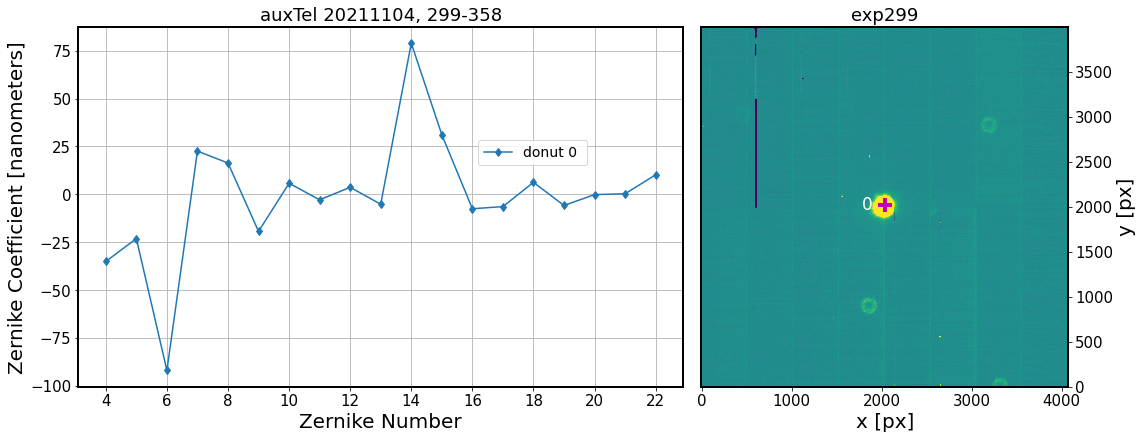

In [63]:
%matplotlib inline
for expI, expE in zip(expIntra,expExtra):
    plot_zernike_image(expIntra=expI, 
                       expExtra=expE, 
                       year='2021', 
                       monthDay='1104'
                      )

Plot results only for the brightest star from across different exposures:

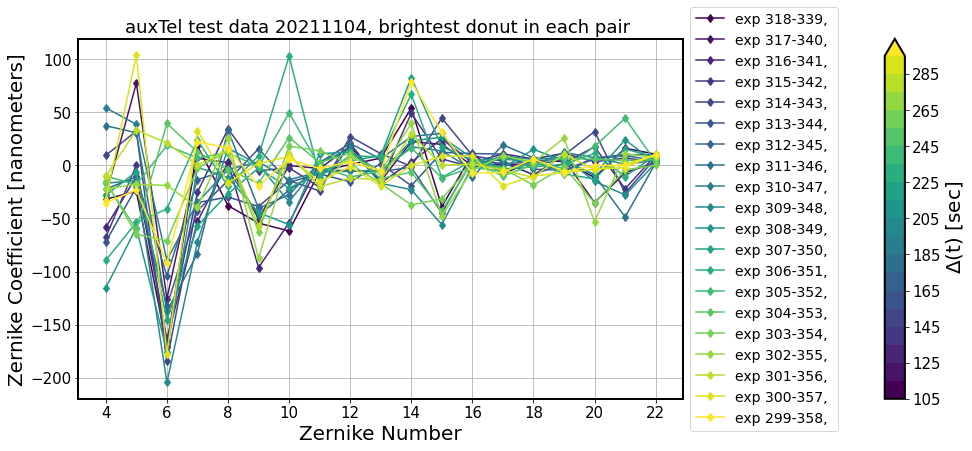

In [65]:
# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

year='2021'
monthDay='1104'
    
####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

nlines = len(expIntra)
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
i = 0 
cmap = plt.cm.viridis
for expI, expE in zip(expIntra,expExtra):
    zkResultsFile = f'zerDic_{year}{monthDay}00{expI}_{expE}_n.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    # plot zernikes only for the 0th donut. 
    # based on the above images, it is the brightest one 
    donutId = 0
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][donutId][0], '-d', color=color,
            label=f'exp {expI}-{expE}, ')
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'exp {expI}-{expE}, ')
    i += 1 

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)

ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
ax1.set_title(f'auxTel test data {year}{monthDay}, brightest donut in each pair ', fontsize=18)

dt = 105+2*np.arange(len(expIntra))*5
bounds = dt
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

#add_axes([xmin,ymin,dx,dy]) 
cax = fig.add_axes([0.8,0,0.02,1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical',
             label=r"$\Delta$(t) [sec]")

As the temporal separation increases the wavefront changes so that the Zernikes measured  are more and more different (the variance increases).

## Stacking exposures to simulate longer integration time

Now add the exposures: `318+317` and `339+340`,  `318+317+316`  and `339+340+341`... And test how adding the postISR images affects the Zernikes retrieved 

First read all exposures into a dictionary:

In [67]:
expIntra=318
year='2021'
monthDay='1104'
datasetRefOrType='postISRCCD'
collection='u/scichris/Latiss/postISRtest'
butler = dafButler.Butler('/repo/main/')
   
# read in all intra consecutive exposures (299..318), show what they look like when added up 
exps = {}
for i in range(20):
    exps[i] = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expIntra-i}')
                                                }, collections=[collection])
   

Display the result  of adding more and more exposures:

318
0
-16.288588 40.27789
317
1
318
-30.285597 93.83586
316
2
318
317
-74.5441 237.80405
315
3
318
317
316
-173.37717 578.9125
314
4
318
317
316
315
-391.37488 1376.9362
313
5
318
317
316
315
314
-884.1555 3172.9395
312
6
318
317
316
315
314
313
-1951.3477 7198.822
311
7
318
317
316
315
314
313
312
-4289.2056 16115.699
310
8
318
317
316
315
314
313
312
311
-9358.5625 35639.344
309
9
318
317
316
315
314
313
312
311
310
-20303.354 78115.89
308
10
318
317
316
315
314
313
312
311
310
309
-43974.906 169898.67
307
11
318
317
316
315
314
313
312
311
310
309
308
-94701.03 367142.94
306
12
318
317
316
315
314
313
312
311
310
309
308
307
-202890.6 788938.44
305
13
318
317
316
315
314
313
312
311
310
309
308
307
306
-378787.53 1468556.0
304
14
318
317
316
315
314
313
312
311
310
309
308
307
306
305
-757591.4 2937119.0
303
15
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
-1515182.8 5874225.5
302
16
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
-3030361.2 11748444.0


IndexError: index 20 is out of bounds for axis 0 with size 20

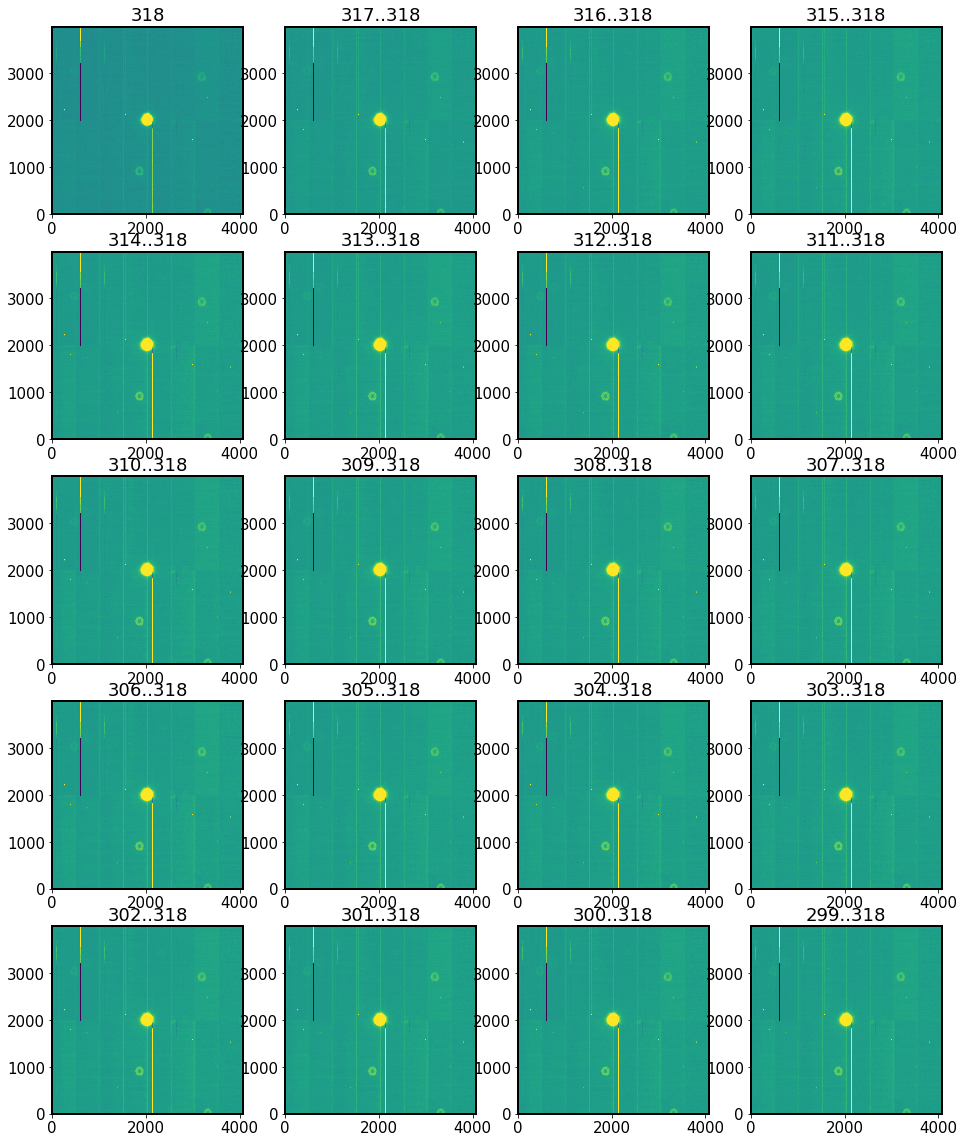

In [70]:
%matplotlib inline
zscale = ZScaleInterval()
edge = 4
nrows, ncols = 5,4
fig,axs = plt.subplots(nrows,ncols,figsize=(ncols*edge,nrows*edge))#figsize=(10,10))
ax = np.ravel(axs)
n = len(exps)

for i in range(n):
    infos = []
    info = exps[i].getInfo()
    expId = str(info.getId())[-3:]
    print(expId)
    infos.append(expId)
    
    data = exps[i].image.array
    print(i)
    for j in range(i):
        #print('+',j)
        info1 = exps[j].getInfo()
        expId = str(info1.getId())[-3:]
        print(expId)
        infos.append(expId)
        data += exps[j].image.array
    
    vmin,vmax = zscale.get_limits(data) 
    print(vmin,vmax) # display the limits to test that the pixel values indeed got added up
    ax[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    if len(infos)<2:
        ax[i].set_title("+".join(infos))
    else:
        ax[i].set_title(f'{infos[0]}..{infos[1]}')
    
while i < n+1 : 
    i += 1
    ax[i].axis('off')
     
fig.subplots_adjust(hspace=0.3)

Read all extra and intra exposures into dictionaries 

In [71]:
exps_intra = {}
exps_extra = {}


butler = dafButler.Butler('/repo/main/')
expIntra=318
expExtra=339
year='2021'
monthDay='1104'
datasetRefOrType='postISRCCD'
collection='u/scichris/Latiss/postISRtest'
    

    
for i in range(20):
    exps_intra[i] = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expIntra-i}')
                                                }, collections=[collection])
    
    exps_extra[i] = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expExtra+i}')
                                                }, collections=[collection])

loading 0
loading 1
loading 2
loading 3
loading 4
loading 5
loading 6
loading 7
loading 8
loading 9
loading 10
loading 11
loading 12
loading 13
loading 14
loading 15
loading 16
loading 17
loading 18
loading 19


Created stacked exposures:

In [ ]:
infoIntra = {}
infoExtra = {}
for i in range(20):
    infos_intra, infos_extra = [],[]
    info_intra = exps_intra[i].getInfo()
    info_extra = exps_extra[i].getInfo()
    expId_intra = str(info_intra.getId())[-3:]
    expId_extra = str(info_extra.getId())[-3:]

    infos_intra.append(expId_intra)
    infos_extra.append(expId_extra)
    
    # base exposure to which we add the ones in the loop below 
    exposure_intra = exps_intra[i]
    exposure_extra = exps_extra[i]
    data_intra = exposure_intra.image.array
    data_extra = exposure_extra.image.array

    for j in range(i): # adding extra exposures 
        info_intra1 = exps_intra[j].getInfo()
        infos_intra.append(str(info_intra1.getId())[-3:])
        data_intra += exps_intra[j].image.array
        
        info_extra1 = exps_extra[j].getInfo()
        infos_extra.append(str(info_extra1.getId())[-3:])
        data_extra += exps_extra[j].image.array
    
    # substitute the data portion of arrays with added data
    exps_intra[i].image.array[:] = data_intra
    exps_extra[i].image.array[:] = data_extra 
    
    # add the information about added exposures
    infoIntra[i] = infos_intra
    infoExtra[i] = infos_extra

Run Zernike estimation:

In [ ]:
camera = butler.get("camera", dataId={"instrument": "LATISS"}, 
                        collections=[collection],)

for i in range(20):
    exposure_pair = [exps_intra[i], exps_extra[i]]    
    exposure_extra = exps_extra[i]
    
    donutCatalog = donutDetectTask.run(exposure_extra)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}_comb_{i}_n.npy'
    np.save(fname,zernikes)
    print(f'Stored the results as {fname} ')

Choose only the brightest donut around `2039, 2022 `

In [51]:
for k in range(20):
    zkResultsFile = f'zerDic_{year}{monthDay}_comb_{k}_n.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()
    # plot zernikes only for the brightest donut which is close to that location:
    p  = Point2D(2039,2022) # usual location of the bright target
    stamps = zkFit['donutStampsExtra'][0]
    points  = stamps.getCentroidPositions()
    print(k, points)

0 [Point2D(2039, 2022), Point2D(465, 2695), Point2D(701, 2574)]
1 [Point2D(470, 2775), Point2D(2039, 2022), Point2D(700, 2457)]
2 [Point2D(450, 2747), Point2D(765, 2535), Point2D(2039, 2023)]
3 [Point2D(729, 2316), Point2D(472, 2396), Point2D(2039, 2023)]
4 [Point2D(728, 2317), Point2D(463, 2369), Point2D(2039, 2023)]
5 [Point2D(2039, 2023)]
6 [Point2D(728, 2317), Point2D(463, 2369), Point2D(2039, 2023)]
7 [Point2D(730, 2316), Point2D(463, 2369), Point2D(2039, 2023)]
8 [Point2D(462, 2732), Point2D(700, 2457), Point2D(2039, 2023)]
9 [Point2D(463, 2369), Point2D(730, 2316), Point2D(2039, 2023)]
10 [Point2D(463, 2369), Point2D(790, 2654), Point2D(2039, 2023)]
11 [Point2D(467, 2398), Point2D(700, 2457), Point2D(2039, 2023)]
12 [Point2D(468, 2378), Point2D(730, 2316), Point2D(2039, 2023)]
13 [Point2D(730, 2316), Point2D(466, 2384), Point2D(2039, 2023)]
14 [Point2D(768, 2726), Point2D(463, 2369), Point2D(2039, 2023)]
15 [Point2D(730, 2316), Point2D(463, 2369), Point2D(2039, 2023)]
16 [Point2

In [53]:
chooseDonut={0:0, 1:1, 5:0}

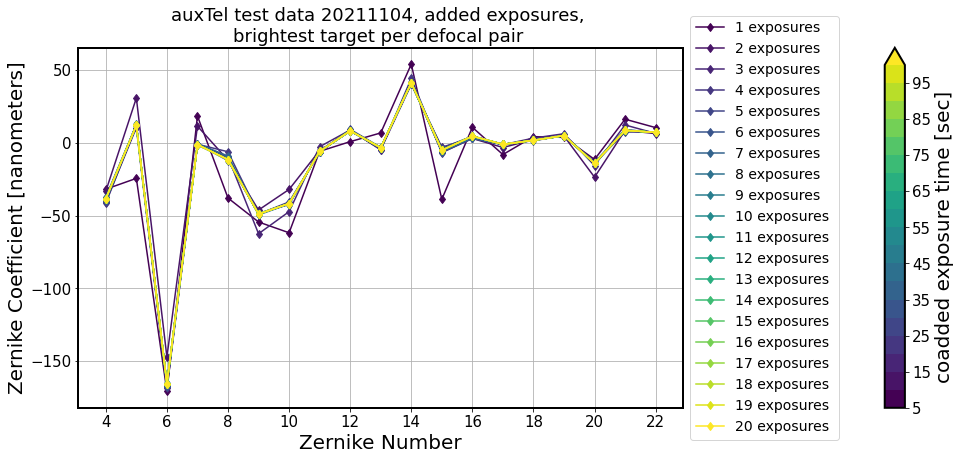

In [58]:
%matplotlib inline
# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

year='2021'
monthDay='1104'
    
####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

nlines = 20#len(exps_intra)
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
i = 0 
cmap = plt.cm.viridis
for k in range(nlines):#len(exps_intra)):
    zkResultsFile = f'zerDic_{year}{monthDay}_comb_{k}_n.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    # plot zernikes only for the brightest donut which is close to that 
    # location. It's usually the last one, based no the list above
    if k in chooseDonut.keys():
        donutId = chooseDonut[k]
    else:
        donutId = 2
    color = cmap(color_idx[i])
    ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][0][donutId], '-d', color=color,
            label=f'{k+1} exposures ')
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'{k+1} ')
    i += 1 

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)

ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
ax1.set_title(f'auxTel test data {year}{monthDay}, added exposures, \nbrightest target per defocal pair ', 
              fontsize=18)

exptime = np.arange(1,21)*5
bounds = exptime
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

#add_axes([xmin,ymin,dx,dy]) 
cax = fig.add_axes([0.8,0,0.02,1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical',
             label="coadded exposure time [sec]")

These appear very similar. So instead, calculate differentials  as we approach the final combined image:

Treating the full stack of 20 exposures as "truth", consider how much closer do we get  to that value as we keep stacking exposures. This is what I plot here - the log of fractional difference between Zk for N-exposure stack vs the 20-exposure stack: 

/tmp/ipykernel_2827870/827551512.py:41: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.arange(4, 23),np.log10(abs(relative)), '-d', color=color,


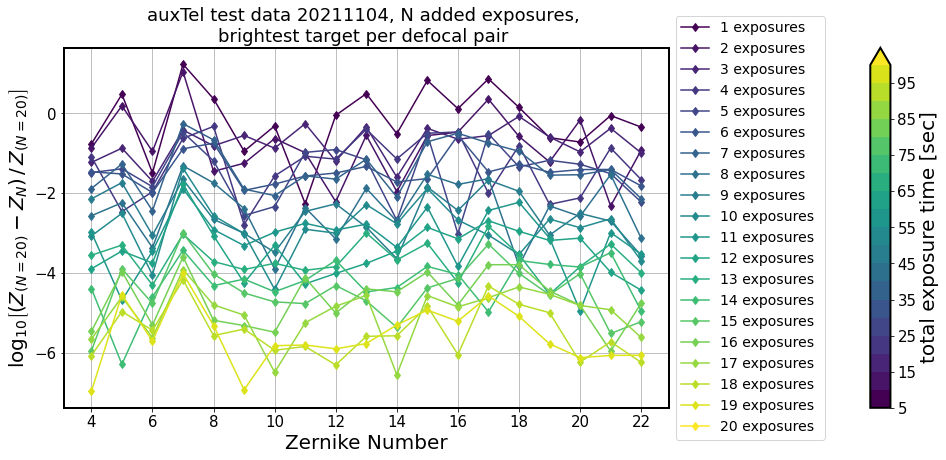

In [62]:
# load the result for final Zk 
k=19
zkResultsFile = f'zerDic_{year}{monthDay}_comb_{k}_n.npy'
zkFit = np.load(zkResultsFile, allow_pickle=True).item()
donutId = 2
if k in chooseDonut.keys():
    donutId = chooseDonut[k]

finalZernikes = 1000*zkFit['outputZernikesRaw'][0][donutId]

fig = plt.figure(figsize=(14, 5))

year='2021'
monthDay='1104'
    
####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

nlines = 20
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
i = 0 
cmap = plt.cm.viridis
for k in range(nlines):
    zkResultsFile = f'zerDic_{year}{monthDay}_comb_{k}_n.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    # plot zernikes only for the 0th donut. 
    # based on the above images, it is the brightest one 
    donutId = 2
    if k in chooseDonut.keys():
        donutId = chooseDonut[k]
    color = cmap(color_idx[i])
    kthZernikes = 1000*zkFit['outputZernikesRaw'][0][donutId]
    difference = finalZernikes  - kthZernikes
    relative = difference / finalZernikes
    ax1.plot(np.arange(4, 23),np.log10(abs(relative)), '-d', color=color,
            label=f'{k+1} exposures ')
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'{k+1} ')
    i += 1 

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel(r'$\log_{10}{\left[\left(Z_{(N=20)}-Z_{N}\right)\,/\,Z_{(N=20)}\right]}$', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1, 0.5],ncol=1)

ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()
ax1.set_title(f'auxTel test data {year}{monthDay}, N added exposures, \nbrightest target per defocal pair ', fontsize=18)

exptime = np.arange(1,21)*5
bounds = exptime
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

#add_axes([xmin,ymin,dx,dy]) 
cax = fig.add_axes([0.8,0,0.02,1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical',
             label="total exposure time [sec]")

This shows that as we combine the exposures, the difference between zernikes derived from the N combined exposures vs total stack of 20 exposures diminishes in a logarithmic fashion.